In [144]:
from glob import glob 
from fastcore.helpers import load_pickle
from gpt3forchem.output import get_polymer_prompt_data, composition_mismatch, polymer_string2performance
from gpt3forchem.data import get_polymer_data
from gpt3forchem.helpers import get_bin_ranges
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

**ToDo: handle the excluded category in the metrics**

In [118]:
polymer_inverse_results = glob('results/20221117_polymer_inverse/*.pkl')

In [119]:
polymer_inverse_results

['results/20221117_polymer_inverse/2022-11-18-13-57-34_results.pkl',
 'results/20221117_polymer_inverse/2022-11-18-00-43-49_results.pkl',
 'results/20221117_polymer_inverse/2022-11-18-09-37-13_results.pkl',
 'results/20221117_polymer_inverse/2022-11-18-11-21-21_results.pkl',
 'results/20221117_polymer_inverse/2022-11-18-01-59-56_results.pkl',
 'results/20221117_polymer_inverse/2022-11-18-01-21-23_results.pkl',
 'results/20221117_polymer_inverse/2022-11-18-13-05-33_results.pkl',
 'results/20221117_polymer_inverse/2022-11-18-14-47-32_results.pkl',
 'results/20221117_polymer_inverse/2022-11-18-15-37-57_results.pkl',
 'results/20221117_polymer_inverse/2022-11-17-23-12-09_results.pkl',
 'results/20221117_polymer_inverse/2022-11-18-02-42-27_results.pkl',
 'results/20221117_polymer_inverse/2022-11-17-23-53-14_results.pkl',
 'results/20221117_polymer_inverse/2022-11-18-12-13-42_results.pkl',
 'results/20221117_polymer_inverse/2022-11-17-22-32-49_results.pkl',
 'results/20221117_polymer_inverse

In [120]:
res = load_pickle(polymer_inverse_results[-3])

In [121]:
res.keys()

dict_keys(['train_file', 'valid_file', 'modelname', 'predictions', 'completions', 'metrics', 'optimal_metrics', 'num_train_points', 'num_test_points', 'exclude_category'])

In [122]:
res['metrics'][0].keys()

dict_keys(['composition_mismatches', 'losses', 'kldiv_score', 'valid_smiles_fraction', 'unique_smiles_fraction', 'novel_smiles_fraction', 'generated_sequences'])

In [133]:
res['metrics'].keys()

dict_keys([0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5])

In [142]:
predictions = [polymer_string2performance(res['metrics'][0]['generated_sequences'][i])['prediction'] for i in range(len(res['metrics'][0]['generated_sequences']))]

(array([[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]]),
 array([-8.747494 , -8.543621 , -8.339749 , -8.135878 , -7.932005 ,
        -7.7281327, -7.5242605, -7.3203883, -7.116516 , -6.912644 ,
        -6.7087717], dtype=float32),
 <a list of 625 BarContainer objects>)

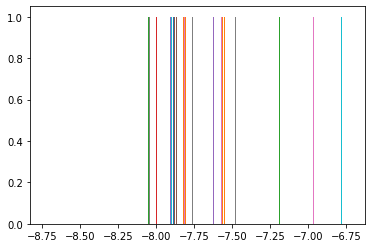

In [143]:
plt.hist(predictions)

In [107]:
bins = get_bin_ranges(get_polymer_data(), "deltaGmin", 5)

<AxesSubplot:xlabel='deltaGmin', ylabel='Density'>

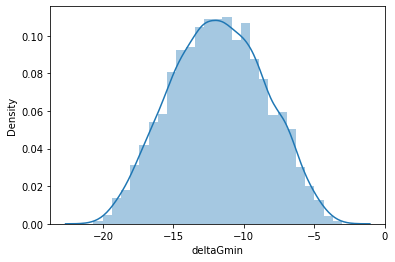

In [147]:
sns.distplot(get_polymer_data()['deltaGmin'])

In [108]:
bins

{0: (-20.691134454177792, -17.145823031111124),
 1: (-17.145823031111124, -13.618149973333342),
 2: (-13.618149973333342, -10.090476915555563),
 3: (-10.090476915555563, -6.562803857777782),
 4: (-6.562803857777782, -3.035130800000002)}

In [88]:
def summarize_at_temperature(subd, t, d):
    val_data = pd.read_json(d['valid_file'], lines=True, orient='records')
    desired_compositions = val_data['prompt'].apply(lambda x: get_polymer_prompt_data(x)[0])
    found_compositions = subd['composition_mismatches']['composition']
    composition_losses =[composition_mismatch(x, y) for x, y in zip(desired_compositions, found_compositions)]
    composition_losses = pd.DataFrame(composition_losses)
    mean_loss = np.mean(subd['losses'])
    mean_composition_mismatch = np.mean(composition_losses['mean'])
    
    mean_min_norm_lev = subd['composition_mismatches']['NormalizedLevenshtein_min'].min()
    mean_mean_norm_lev = subd['composition_mismatches']['NormalizedLevenshtein_mean'].mean()
    longest_common_subs_max_mean = (subd['composition_mismatches']['LongestCommonSubsequence_max']/subd['composition_mismatches']['smiles'].apply(lambda x: len(x))).mean()
    longest_common_subs_mean_mean = (subd['composition_mismatches']['LongestCommonSubsequence_mean']/subd['composition_mismatches']['smiles'].apply(lambda x: len(x))).mean()

    return {
        'mean_loss': mean_loss, 
        'mean_composition_mismatch': mean_composition_mismatch, 
        'mean_min_norm_lev': mean_min_norm_lev,
        'mean_mean_norm_lev': mean_mean_norm_lev, 
        'longest_common_subs_max_mean': longest_common_subs_max_mean,
        'frac_valid': subd['valid_smiles_fraction'],
        'frac_novel': subd['novel_smiles_fraction'],
        'frac_unique': subd['unique_smiles_fraction'],
        'kldiv': subd['kldiv_score'],
        'exclude_category': d['exclude_category'] if 'exclude_category' in d and d['exclude_category'] else "None",
    }

In [89]:
combined_results = []
optimal_results = []
for res in polymer_inverse_results: 
    try:
        d = load_pickle(res) 
        for t, td in d['metrics'].items():
            td_sum = summarize_at_temperature(td, t, d)
            td_sum['temperature'] = t

            combined_results.append(td_sum)


        td_sum = summarize_at_temperature(d['optimal_metrics'], t, d)

        optimal_results.append(td_sum)
    except Exception as e:
        print(e)
        pass

tuple indices must be integers or slices, not str


In [90]:
combined_results

[{'mean_loss': 3.1831838672622568,
  'mean_composition_mismatch': 0.2364217252396166,
  'mean_min_norm_lev': 0.23076923076923078,
  'mean_mean_norm_lev': 0.39776472262916895,
  'longest_common_subs_max_mean': 0.46317247249908217,
  'frac_valid': 1.0,
  'frac_novel': 0.9041533546325878,
  'frac_unique': 0.9041533546325878,
  'kldiv': 0.7320543462034269,
  'exclude_category': 'None',
  'temperature': 0},
 {'mean_loss': 3.1161642055510743,
  'mean_composition_mismatch': 0.2356230031948882,
  'mean_min_norm_lev': 0.20930232558139536,
  'mean_mean_norm_lev': 0.40535658238788075,
  'longest_common_subs_max_mean': 0.4727222487058808,
  'frac_valid': 1.0,
  'frac_novel': 1.0,
  'frac_unique': 1.0,
  'kldiv': 0.9737706489468884,
  'exclude_category': 'None',
  'temperature': 0.25},
 {'mean_loss': 3.0562803322483587,
  'mean_composition_mismatch': 0.23722044728434505,
  'mean_min_norm_lev': 0.23529411764705882,
  'mean_mean_norm_lev': 0.409555279597167,
  'longest_common_subs_max_mean': 0.478827

In [91]:
combined_results = pd.DataFrame(combined_results)
optimal_results = pd.DataFrame(optimal_results)

In [92]:
combined_results.groupby('exclude_category').mean()

,mean_loss,mean_composition_mismatch,mean_min_norm_lev,mean_mean_norm_lev,longest_common_subs_max_mean,frac_valid,frac_novel,frac_unique,kldiv,temperature
exclude_category,,,,,,,,,,
None,3.097136,0.948711,0.231964,0.411237,0.468905,0.993163,0.983450,0.983450,0.895397,0.735
very large,1.240223,0.657578,0.216544,0.429968,0.418076,0.993257,0.898743,0.898743,0.643746,0.750


In [93]:
agg_frame = combined_results[['temperature', 'longest_common_subs_max_mean', 'mean_composition_mismatch', 'mean_loss', 'frac_valid', 'frac_novel', 'frac_unique', 'kldiv', 'exclude_category']].round(2).groupby(by=['temperature', 'exclude_category']).agg(['mean', 'std', 'count'])
agg_frame

longest_common_subs_max_mean                  \
                                                     mean       std count   
temperature exclude_category                                                
0.00        None                                 0.448750  0.016421     8   
            very large                           0.400000  0.000000     2   
0.25        None                                 0.457143  0.014960     7   
            very large                           0.410000  0.000000     2   
0.50        None                                 0.465714  0.013973     7   
            very large                           0.420000  0.000000     2   
0.75        None                                 0.465714  0.013973     7   
            very large                           0.420000  0.000000     2   
1.00        None                                 0.468571  0.015736     7   
            very large                           0.420000  0.000000     2   
1.25        None                                 0.475714  0.013973     7   
            very large                           0.425000  0.007071     2   
1.50        None                                 0.497143  0.017995     7   
            very large                           0.430000  0.000000     2   

                             mean_composition_mismatch                  \
                                                  mean       std count   
temperature exclude_category                                             
0.00        None                              0.237500  0.010351     8   
            very large                        0.245000  0.007071     2   
0.25        None                              0.235714  0.011339     7   
            very large                        0.245000  0.007071     2   
0.50        None                              0.238571  0.010690     7   
            very large                        0.245000  0.007071     2   
0.75        None                              0.318571  0.212480     7   
            very large                        0.245000  0.007071     2   
1.00        None                              0.534286  0.598856     7   
            very large                        0.440000  0.070711     2   
1.25        None                              1.657143  1.200746     7   
            very large                        0.790000  0.014142     2   
1.50        None                              3.522857  0.154673     7   
            very large                        2.390000  0.028284     2   

                             mean_loss                 frac_valid  ...        \
                                  mean       std count       mean  ... count   
temperature exclude_category                                       ...         
0.00        None              3.113750  0.052082     8   1.000000  ...     8   
            very large        0.880000  0.070711     2   1.000000  ...     2   
0.25        None              3.095714  0.025071     7   1.000000  ...     7   
            very large        1.140000  0.028284     2   1.000000  ...     2   
0.50        None              3.081429  0.015736     7   1.000000  ...     7   
            very large        1.255000  0.021213     2   1.000000  ...     2   
0.75        None              3.065714  0.025071     7   1.000000  ...     7   
            very large        1.330000  0.042426     2   1.000000  ...     2   
1.00        None              3.084286  0.022991     7   0.998571  ...     7   
            very large        1.345000  0.035355     2   1.000000  ...     2   
1.25        None              3.100000  0.016330     7   0.994286  ...     7   
            very large        1.375000  0.021213     2   1.000000  ...     2   
1.50        None              3.140000  0.049666     7   0.958571  ...     7   
            very large        1.360000  0.014142     2   0.960000  ...     2   

                             frac_novel                 frac_unique            \
                  

In [61]:
optimal_results.agg(['mean', 'std'])

,mean_loss,mean_composition_mismatch,mean_min_norm_lev,mean_mean_norm_lev,longest_common_subs_max_mean,frac_valid,frac_novel,frac_unique,kldiv
mean,3.102406,0.0,0.241295,0.398214,0.471575,1.0,1.0,1.0,0.986653
std,0.026820,0.0,0.014233,0.004026,0.013839,0.0,0.0,0.0,0.002894


In [54]:
def create_classification_performance_table(df):
    rows = []
    row_template = "{temperature} & \\num⁍ {frac_valid} \\pm {frac_valid_std} ⁌ &   \\num⁍ {frac_novel} \\pm {frac_novel_std} ⁌   &  \\num⁍ {kl_div} \\pm {kl_div_std} ⁌   & \\num⁍ {longest_common_subs_max_mean} \\pm {longest_common_subs_max_mean_std}  ⁌ & \\num⁍ {mean_composition_mismatch} \\pm {mean_composition_mismatch_std} ⁌  & \\num⁍ {mean_loss} \\pm {mean_loss_std} ⁌    \\\\"
    for i, row in df.round(2).iterrows():
        row_dict = {
            "temperature": row.name,
            "frac_valid": row["frac_valid"]["mean"],
            "frac_valid_std": row["frac_valid"]["std"],
            "frac_novel": row["frac_novel"]["mean"],
            "frac_novel_std": row["frac_novel"]["std"],
            "kl_div": row["kldiv"]["mean"],
            "kl_div_std": row["kldiv"]["std"],
            "longest_common_subs_max_mean": row["longest_common_subs_max_mean"]["mean"],
            "longest_common_subs_max_mean_std": row["longest_common_subs_max_mean"]["std"],
            "mean_composition_mismatch": row["mean_composition_mismatch"]["mean"],
            "mean_composition_mismatch_std": row["mean_composition_mismatch"]["std"],
            "mean_loss": row["mean_loss"]["mean"],
            "mean_loss_std": row["mean_loss"]["std"],
        }
        rows.append(row_template.format(**row_dict).replace("⁍", "{").replace("⁌", "}"))
    return rows

In [58]:
print('\n'.join(create_classification_performance_table(agg_frame)))

0.0 & \num{ 1.0 \pm 0.0 } &   \num{ 0.9 \pm 0.02 }   &  \num{ 0.73 \pm 0.01 }   & \num{ 0.45 \pm 0.02  } & \num{ 0.24 \pm 0.01 }  & \num{ 3.11 \pm 0.05 }    \\
0.25 & \num{ 1.0 \pm 0.0 } &   \num{ 1.0 \pm 0.0 }   &  \num{ 0.97 \pm 0.01 }   & \num{ 0.46 \pm 0.01  } & \num{ 0.24 \pm 0.01 }  & \num{ 3.1 \pm 0.03 }    \\
0.5 & \num{ 1.0 \pm 0.0 } &   \num{ 1.0 \pm 0.0 }   &  \num{ 0.95 \pm 0.01 }   & \num{ 0.47 \pm 0.01  } & \num{ 0.24 \pm 0.01 }  & \num{ 3.08 \pm 0.02 }    \\
0.75 & \num{ 1.0 \pm 0.0 } &   \num{ 1.0 \pm 0.0 }   &  \num{ 0.93 \pm 0.01 }   & \num{ 0.47 \pm 0.01  } & \num{ 0.32 \pm 0.21 }  & \num{ 3.07 \pm 0.03 }    \\
1.0 & \num{ 1.0 \pm 0.0 } &   \num{ 1.0 \pm 0.0 }   &  \num{ 0.91 \pm 0.01 }   & \num{ 0.47 \pm 0.02  } & \num{ 0.53 \pm 0.6 }  & \num{ 3.08 \pm 0.02 }    \\
1.25 & \num{ 0.99 \pm 0.01 } &   \num{ 1.0 \pm 0.0 }   &  \num{ 0.9 \pm 0.02 }   & \num{ 0.48 \pm 0.01  } & \num{ 1.66 \pm 1.2 }  & \num{ 3.1 \pm 0.02 }    \\
1.5 & \num{ 0.96 \pm 0.02 } &   \num{ 1.0 \pm